## Import Packages

In [30]:
# import data processing and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import image processing libraries
import cv2
import skimage
from skimage.transform import resize

# import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
import os

## Load Data

In [31]:
#기본 Parameter 설정
BATCHSIZE = 25
imageSize = 60
target_dims = (imageSize, imageSize, 3)
num_classes = 11 #0~10까지 총 11개
train_len = 1534 #총 파일 수

train_dir = "../input/full/" #train 폴더 경로 지정(끝에 / 까지 쳐야함)

In [ ]:
from tqdm import tqdm #진행상황바 표시해주는 패키지

def get_data(folder, data_len): #data불러오는 함수
    
    X = np.empty((data_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((data_len,), dtype=np.int)
    cnt = 0

    for folderName in os.listdir(folder): #기존 ASL alphabet용 코드를 약간 변형시켜줌
        if not folderName.startswith('.'):
            if folderName in ['00']: #label이 0부터 시작하게 하려고 0 사진 다운 받아둠
                label = 0
            elif folderName in ['01']:
                label = 1
            elif folderName in ['02']:
                label = 2
            elif folderName in ['03']:
                label = 3
            elif folderName in ['04']:
                label = 4
            elif folderName in ['05']:
                label = 5
            elif folderName in ['06']:
                label = 6
            elif folderName in ['07']:
                label = 7
            elif folderName in ['08']:
                label = 8
            elif folderName in ['09']:
                label = 9
            elif folderName in ['10']:
                label = 10
            for image_filename in tqdm(os.listdir(folder + folderName)):
              img_file = cv2.imread(folder + folderName + '/' + image_filename)
              if img_file is not None:
                img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3)) #image 사이즈 조정
                img_arr = np.asarray(img_file)
                
                X[cnt] = img_arr
                y[cnt] = label
                cnt += 1

    return X,y

In [ ]:
X_train, y_train = get_data(train_dir,train_len)

In [32]:
#pickle 파일 load

import pickle

with open("../pickle/X_train_220602_imagesize_60_full","rb") as file :
    X_train=pickle.load(file)
    
with open("../pickle/y_train_220602_imagesize_60_full","rb") as file2 :
    y_train=pickle.load(file2)

In [33]:
#data 불러온 결과 shape출력(데이터수, imageSize, imageSize, 3) : get_data함수에서 설정해준 항목
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)
print("The shape of one image is : ", X_train[0].shape)

The shape of X_train is :  (1534, 60, 60, 3)
The shape of y_train is :  (1534,)
The shape of one image is :  (60, 60, 3)


In [ ]:
#혹시 몰라 나중에 쓸 수도 있어 pickle파일 만들어봄(건너뛰어도 무관)
import pickle

X_train_220602_imagesize_60_full=X_train
y_train_220602_imagesize_60_full=y_train


with open("../pickle/X_train_220602_imagesize_60_full","wb") as file :
    pickle.dump(X_train_220602_imagesize_60_full,file)
with open("../pickle/y_train_220602_imagesize_60_full","wb") as file :
    pickle.dump(y_train_220602_imagesize_60_full,file)
    

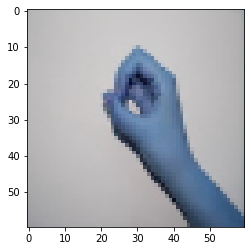

In [34]:
#예시로 이미지 출력
plt.imshow(X_train[0])
plt.show()

In [35]:
#Making copies of original data
X_data = X_train
y_data = y_train

In [36]:
#있는 데이터로 train, test split해주는 함수, test_size에서 비율 조정 가능
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

In [37]:
#train,test split된 것 출력해서 확인
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1073, 60, 60, 3)
(1073,)
(461, 60, 60, 3)
(461,)


## Modeling

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.applications import VGG16

In [39]:
VGG16_transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=target_dims)

In [40]:
VGG16_transfer_model.trainable=False

In [57]:
#Early Stopping함수를 이용해서 patience수가 넘어가면 자동으로 Early Stopping되게 함
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [42]:
VGG16_model_tr = Sequential([
    VGG16_transfer_model, 
    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(11, activation='softmax')
])

In [43]:
#Compiling
VGG16_model_tr.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
#Model fitting
VGG16_model_tr.fit(X_train, y_train,
          epochs=100,
          batch_size=BATCHSIZE,
          verbose=2,
          validation_data=(X_test, y_test),
          callbacks=[early_stop])

Epoch 1/100
43/43 - 40s - loss: 0.1285 - accuracy: 0.9776 - val_loss: 0.4451 - val_accuracy: 0.8959 - 40s/epoch - 938ms/step
Epoch 2/100
43/43 - 43s - loss: 0.1261 - accuracy: 0.9804 - val_loss: 0.4232 - val_accuracy: 0.9067 - 43s/epoch - 997ms/step
Epoch 3/100
43/43 - 43s - loss: 0.1242 - accuracy: 0.9776 - val_loss: 0.4314 - val_accuracy: 0.9024 - 43s/epoch - 989ms/step
Epoch 4/100
43/43 - 42s - loss: 0.1177 - accuracy: 0.9870 - val_loss: 0.4391 - val_accuracy: 0.8959 - 42s/epoch - 982ms/step
Epoch 5/100
43/43 - 43s - loss: 0.1095 - accuracy: 0.9842 - val_loss: 0.4154 - val_accuracy: 0.8915 - 43s/epoch - 1s/step
Epoch 6/100
43/43 - 43s - loss: 0.1129 - accuracy: 0.9851 - val_loss: 0.4231 - val_accuracy: 0.9111 - 43s/epoch - 994ms/step
Epoch 7/100
43/43 - 43s - loss: 0.1043 - accuracy: 0.9870 - val_loss: 0.4207 - val_accuracy: 0.8937 - 43s/epoch - 998ms/step
Epoch 8/100
43/43 - 43s - loss: 0.1013 - accuracy: 0.9897 - val_loss: 0.4406 - val_accuracy: 0.8937 - 43s/epoch - 992ms/step


## Result

In [46]:
#Model metrics
metrics = pd.DataFrame(VGG16_model_tr.history.history)
print("The model metrics are")
metrics

The model metrics are


,loss,accuracy,val_loss,val_accuracy
0,2.293053,0.188257,2.094246,0.281996
1,1.948519,0.384902,1.796698,0.520607
2,1.662193,0.539609,1.583191,0.553145
3,1.435421,0.597390,1.392094,0.587852
4,1.250703,0.655172,1.266284,0.631236
5,1.104049,0.714818,1.157360,0.659436
6,0.994644,0.726002,1.104979,0.687636
7,0.903687,0.775396,1.010550,0.674620
8,0.824749,0.778192,0.970844,0.702820
9,0.766416,0.805219,0.889363,0.735358


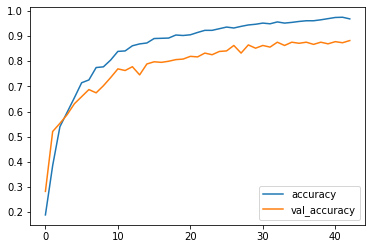

In [47]:
#저장된 accuracy 그래프로 출력
metrics[['accuracy','val_accuracy']].plot()
plt.show()

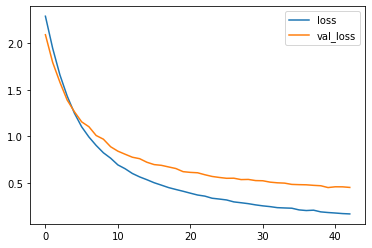

In [48]:
#저장된 loss 그래프로 출력
metrics[['loss','val_loss']].plot()
plt.show()

In [50]:
#Model evaluation
VGG16_model_tr.evaluate(X_test,y_test,verbose=0)

[0.45205551385879517, 0.8828633427619934]

In [52]:
y_predictions=VGG16_model_tr.predict(X_test)
predictions=y_predictions.argmax(axis=1)

15/15 [==============================] - 8s 506ms/step


In [53]:
#Report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.86      0.88      0.87        41
           2       0.76      0.93      0.83        40
           3       0.80      0.88      0.84        41
           4       0.92      0.85      0.89        41
           5       1.00      0.93      0.96        42
           6       0.85      0.85      0.85        41
           7       0.72      0.71      0.72        41
           8       0.91      0.95      0.93        41
           9       0.92      0.88      0.90        41
          10       1.00      0.90      0.95        71

    accuracy                           0.88       461
   macro avg       0.89      0.89      0.88       461
weighted avg       0.89      0.88      0.88       461



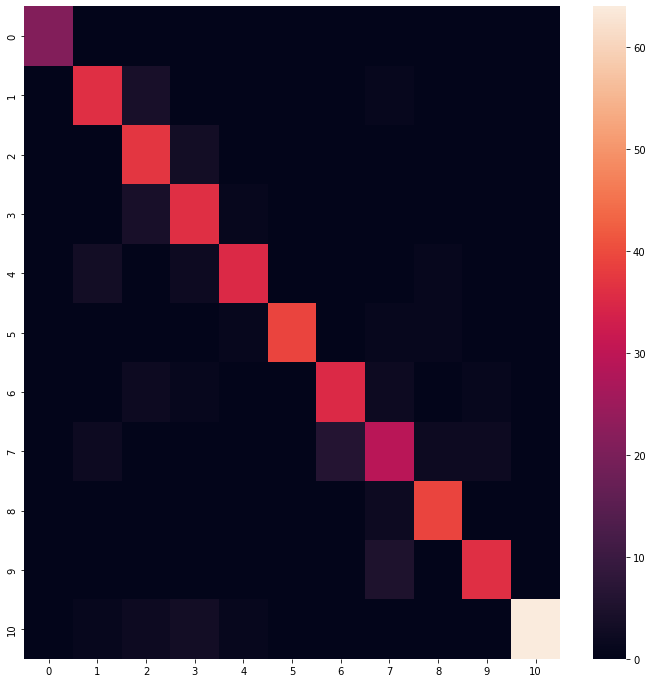

In [54]:
#Confusion matrix로 표시
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test,predictions))
plt.show()